# Example usage with pennylane
This notebook shows some examples of generating Quantum Convolutional Neural Networks (QCNNs)

___
*A cute robot building itself with artifical intelligence, pencil drawing -  generated with* [Dall$\cdot$E 2](https://openai.com/dall-e-2/)

<img src="../img/DALL·E 2022-08-17 11.48.32 - A cute robot building itself with artifical intelligence, pencil drawing.png" alt="drawing" width="200"/>

In [19]:
# Load libraries
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml

In [20]:
# Core
from dynamic_qcnn import (
    Qcnn,
    Qfree,
    Qconv,
    Qpool,
    Qdense,
    plot_graph,
)

In [28]:
# Specific to Pennylane
from dynamic_qcnn.pennylane import get_param_info_pennylane, execute_circuit_pennylane 

# Specify QNode
dev = qml.device("default.qubit", wires=[i+1 for i in range(8)])

@qml.qnode(dev)
def circuit(motif, params):
    response_wire = motif.head.Q_avail[-1] # This is the 'last' available qubit
    execute_circuit_pennylane(motif, params) # This executes the compute graph in order
    return qml.expval(qml.PauliZ(response_wire))

# Specify drawer
qml.drawer.use_style("black_white")

### Basic example
We create one of the architectures discussed in [Lourens et al.](https://arxiv.org/pdf/2210.15073.pdf). This architecture is semantically described as repeating a convolution of stride 1 and pooling from bottom to top on 8 qubits until one remain.

<img src="../img/hierarchical_motifs.drawio.svg" alt="hierarchical motifs" width="900"/>

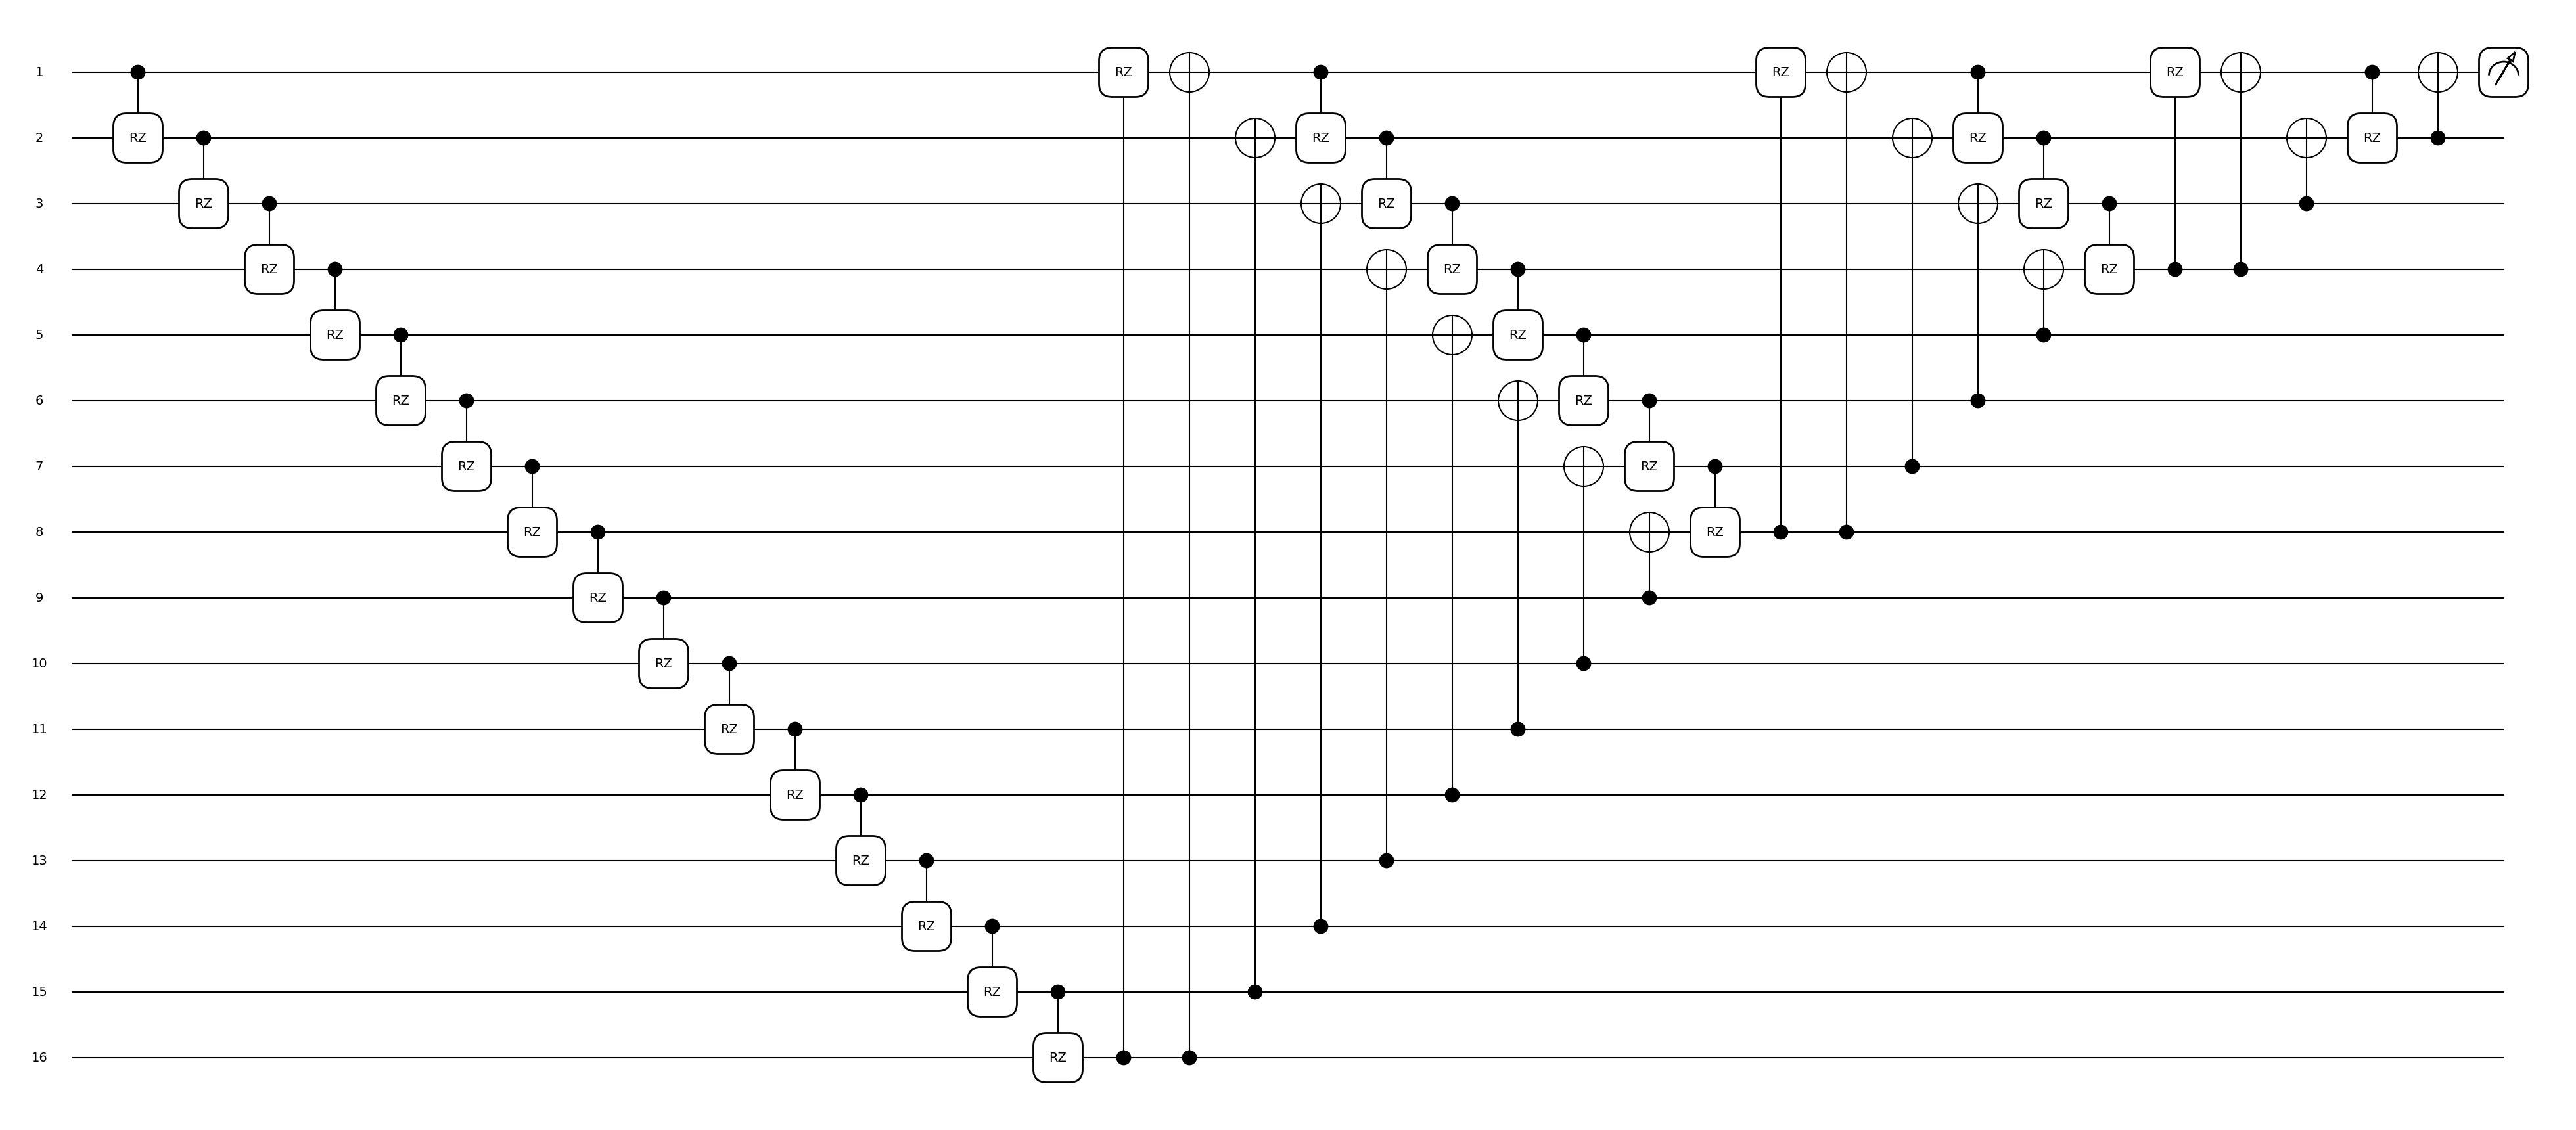

In [29]:
# Build circuit
m = Qfree(16) + (Qconv(1) + Qpool(filter="right")) * 4

# Get param info
total_coef_count, coef_indices  = get_param_info_pennylane(m)
params = np.random.uniform(0,np.pi,total_coef_count)

# Draw
fig, ax = qml.draw_mpl(circuit)(m, params)

In [24]:
print(f"Number of coefficients:{total_coef_count}")
print(f"Coefficients per layer:\n{coef_indices}")

Number of coefficients:4
Coefficients per layer:
{0: range(0, 1), 1: None, 2: range(1, 2), 3: None, 4: range(2, 3), 5: None, 6: range(3, 4), 7: None}


In [25]:
# Execute the circuit
print(circuit(motif, params))

1.0


### Building blocks
Circuit architectures are created by stacking motifs hierarchacially, the lowest level motifs (primitives) are building blocks for higher level ones. On a high level you can regard a primitive as a layer such as convolution or pooling and we're creating a sequence of layers for the circuit. This view only captures hierarchical architectures of two levels (*level 1 -> primitives, level 2 -> sequence of primitves*). The framework is more general in that there is no limit to the number of levels used to represent an architecture. See the comparison below:

**Layer view**
 - qcnn = (Convolution, Pooling, Convolution, Pooling, Convolution, Convolution, Convolution, Pooling, Convolution, Pooling)

**Hierarchical view**
 - m2_1 = (Convolution, Pooling)
 - m2_2 = (Convolution, Convolution)
 - m3_1 = (m2_1, m2_1)
 - qcnn = (m3_1, m2_2, m3_1)

#### Convolution primitive

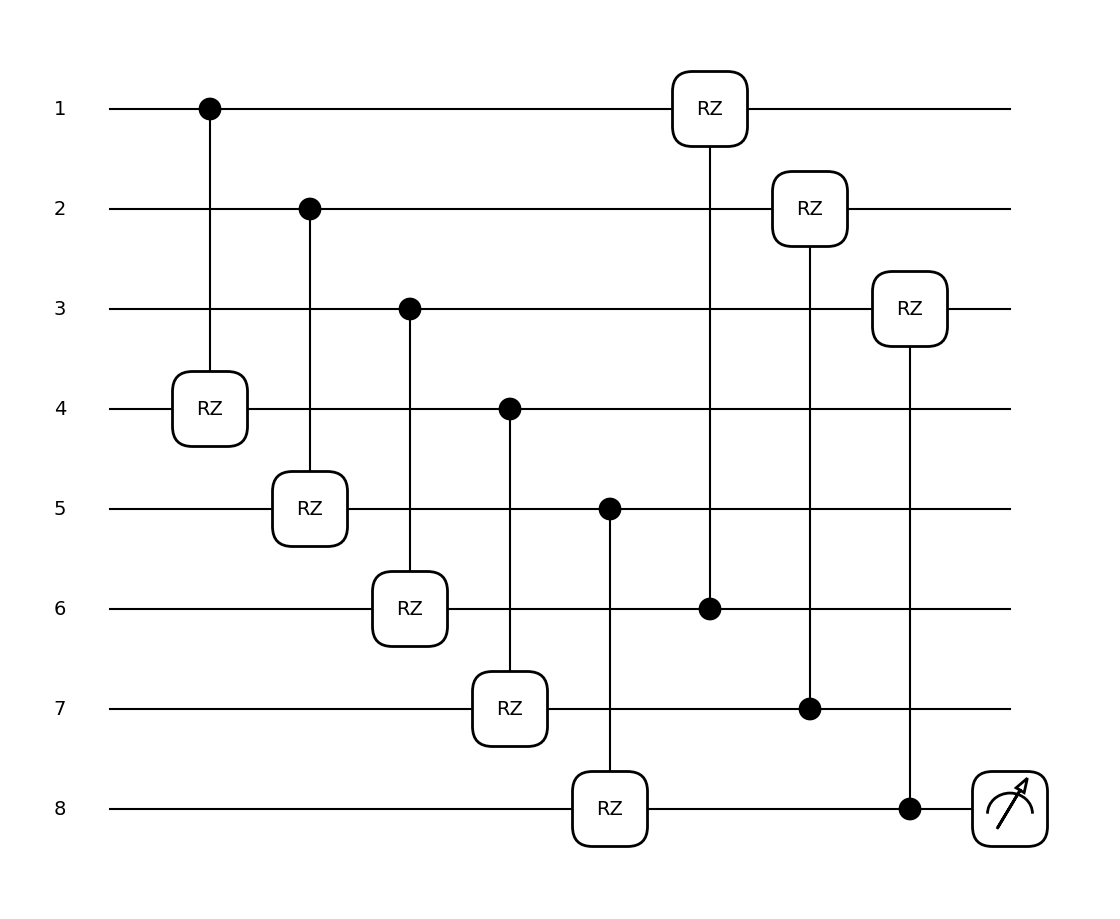

In [30]:
# Convolution of stride 3, try out other stride values
convolution = Qconv(3) 
conv_on_8_qubits = Qfree(8) + convolution

# Get param info
total_coef_count, coef_indices  = get_param_info_pennylane(conv_on_8_qubits)
params = np.random.uniform(0,np.pi,total_coef_count)

# Draw
fig, ax = qml.draw_mpl(circuit)(conv_on_8_qubits, params)

#### Pooling primitive

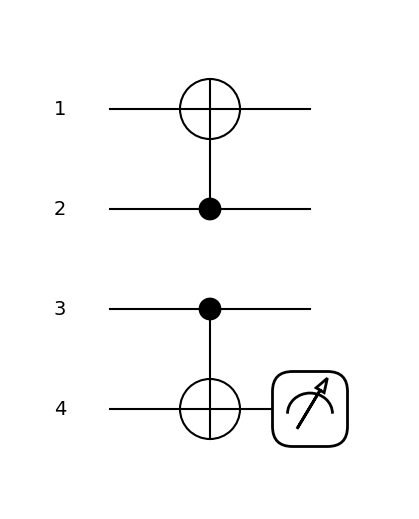

In [31]:
# Pooling from inside out, other values for filter: right, left, inside, outside, even, odd or a bitstring like 0100
pooling = Qpool(filter="inside")
pool_on_4_qubits = Qfree(4) + pooling

# Get param info
total_coef_count, coef_indices  = get_param_info_pennylane(pool_on_4_qubits)
params = np.random.uniform(0,np.pi,total_coef_count)

# Draw
fig, ax = qml.draw_mpl(circuit)(pool_on_4_qubits, params)

#### Dense primitive

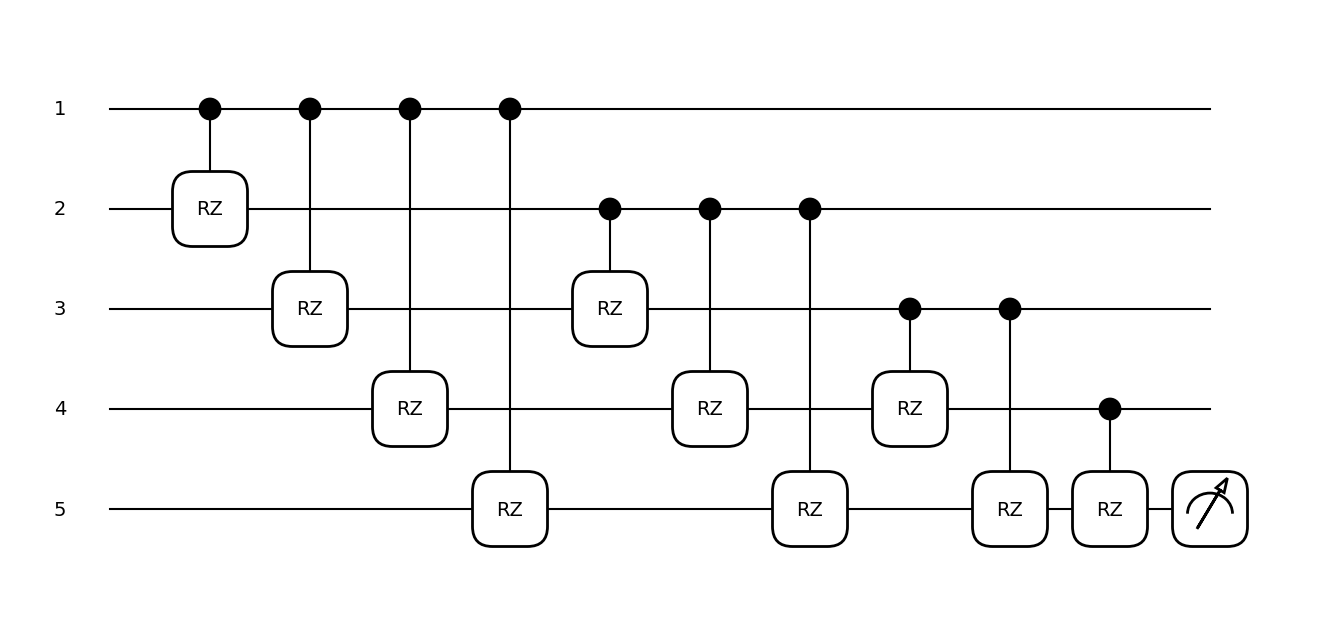

In [32]:
# Dense primitive, does all pairwise combinations between available qubits, for all permutations set permutations=True
dense = Qdense(permutations=False)
dense_on_5_qubits = Qfree(5) + dense

# Get param info
total_coef_count, coef_indices  = get_param_info_pennylane(dense_on_5_qubits)
params = np.random.uniform(0,np.pi,total_coef_count)

# Draw
fig, ax = qml.draw_mpl(circuit)(dense_on_5_qubits, params)

#### Free qubit primitive

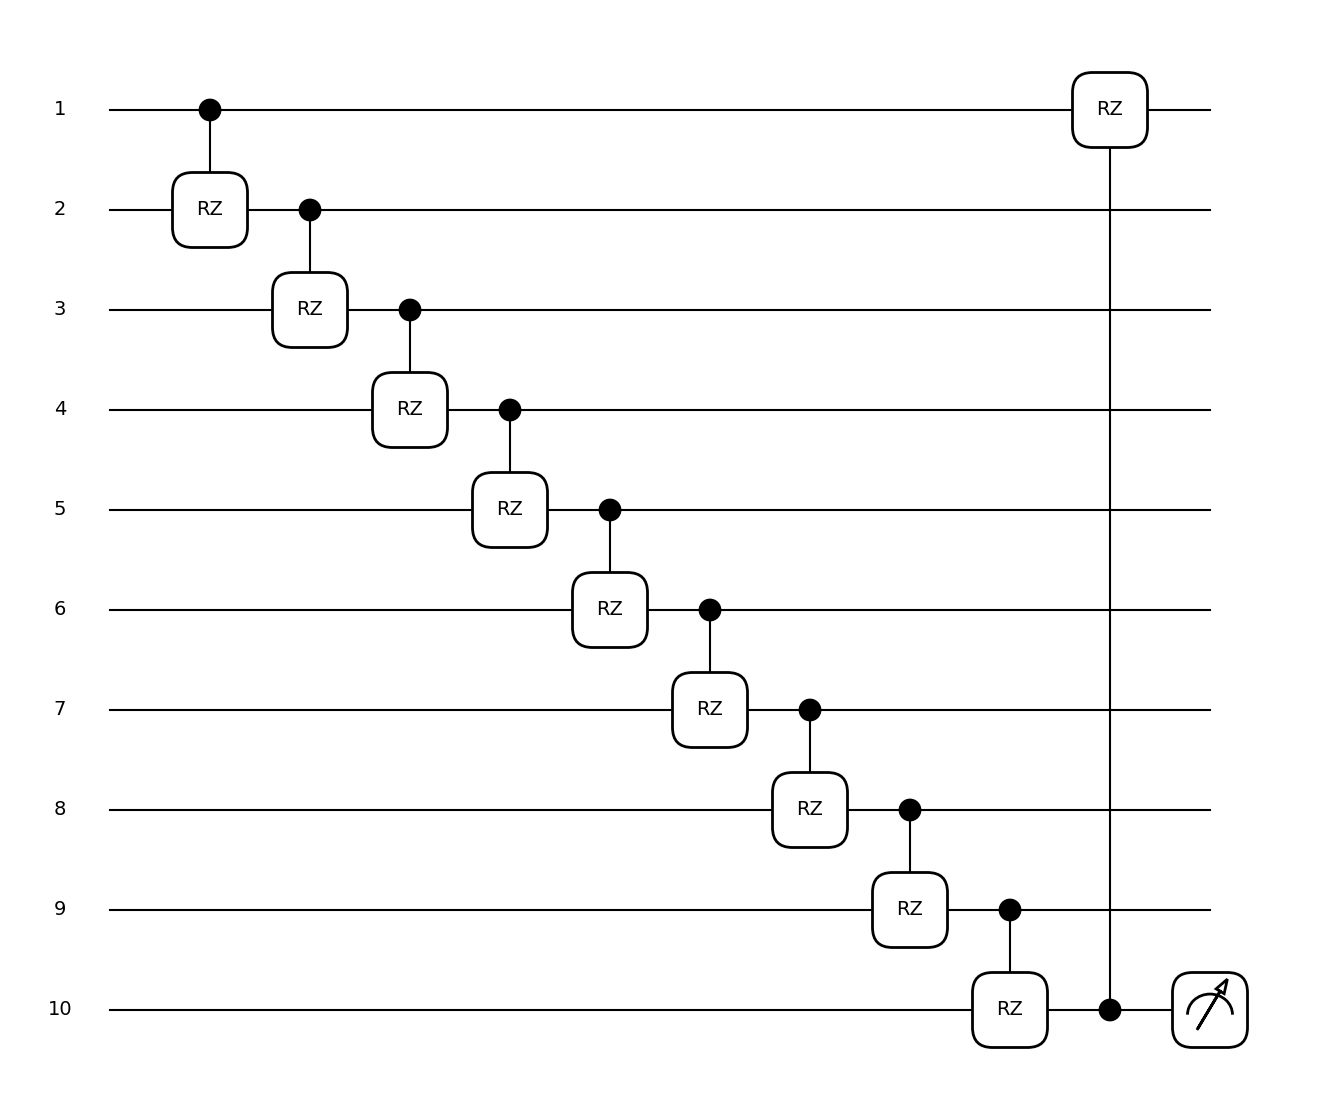

In [34]:
# Free primitive, can also recieve a list of qubit labels to make available.
free = Qfree(10)
convolution_on_10_qubits = free + Qconv(1)

# Get param info
total_coef_count, coef_indices  = get_param_info_pennylane(convolution_on_10_qubits)
params = np.random.uniform(0,np.pi,total_coef_count)

# Draw
fig, ax = qml.draw_mpl(circuit)(convolution_on_10_qubits, params)

## Reverse binary tree

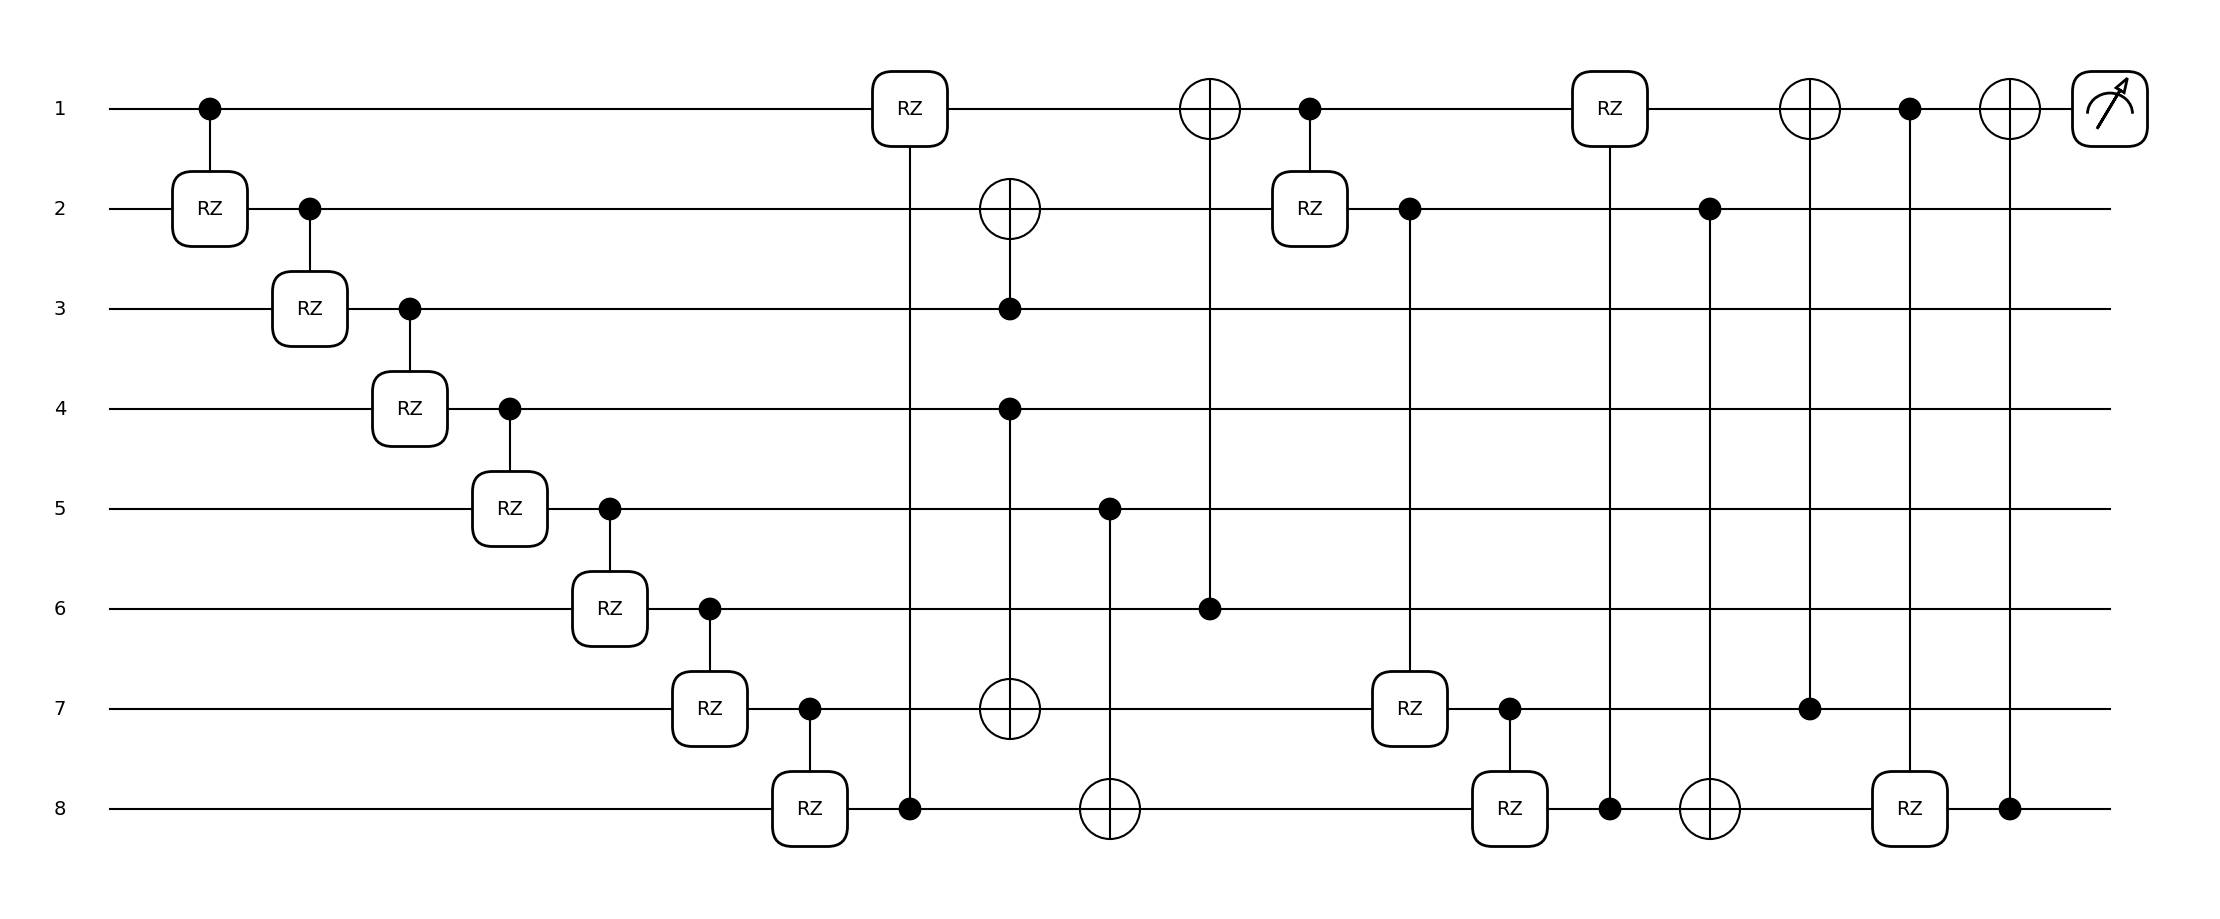

In [35]:
### Reverse binary tree

# Change these values
#---------
N = 8 # any power of two
s_c = 1 # 1,2,3, ...
f = "inside" # right, left, inside, outside, even, odd
s_p = 1 # 1,2,3, ...
#---------

# level 1
m1_1 = Qconv(stride=s_c)
m1_2 = Qpool(stride=s_p, filter=f)
# level 2
m2_1 = m1_1 + m1_2
# level 3
m3_1 = Qfree(N) + m2_1 * int(np.log2(N))

# Get param info
total_coef_count, coef_indices  = get_param_info_pennylane(m3_1)
params = np.random.uniform(0,np.pi,total_coef_count)

# Draw
fig, ax = qml.draw_mpl(circuit)(m3_1, params)

### More arbitrary examples to show what is possible

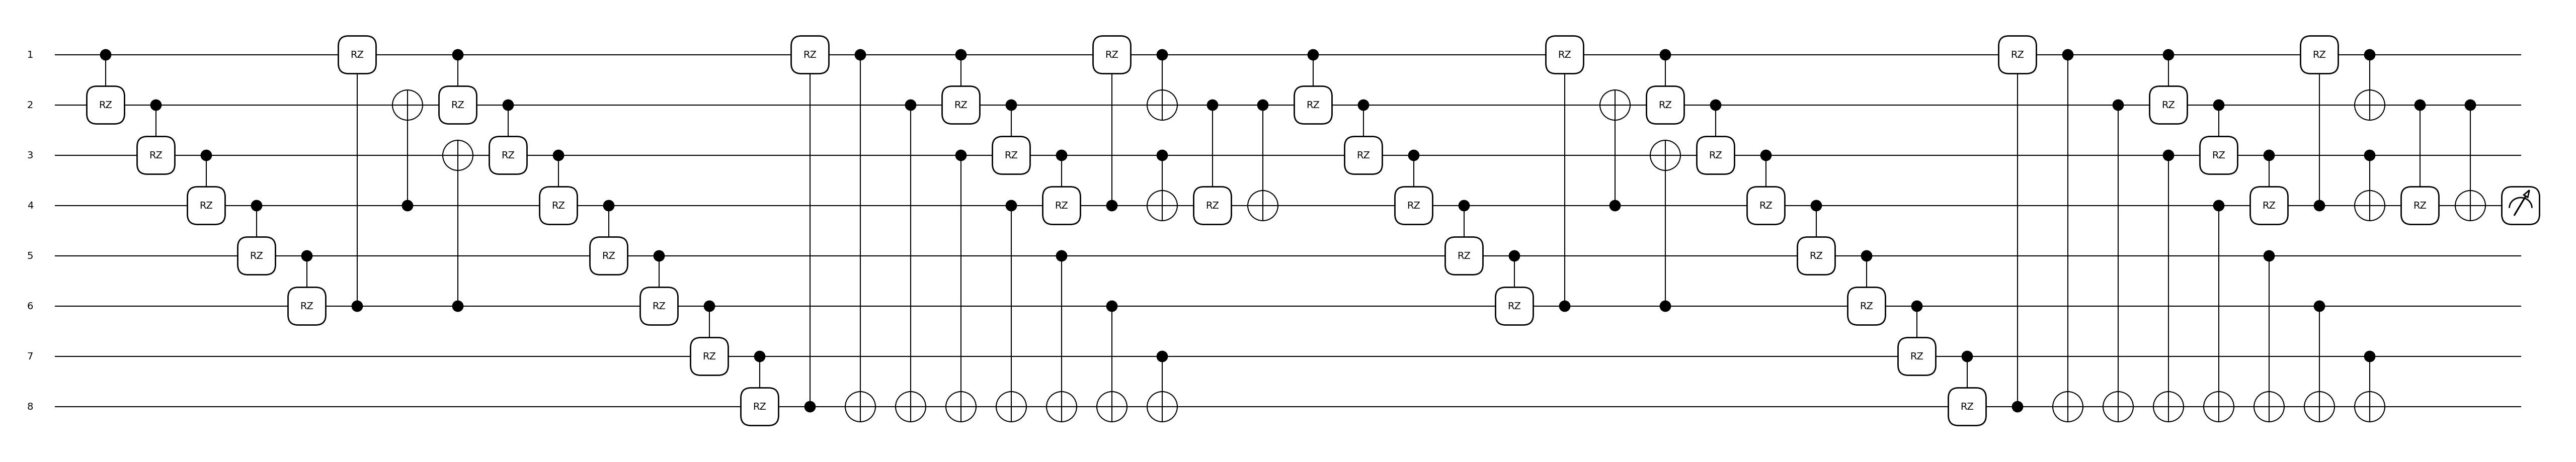

In [36]:
m1 = Qfree(6) + Qconv()
m2 = m1 + Qpool(1, "000101")
m3 = m2 + Qfree(8) + Qconv(1) + Qpool(2, "11111110")
m4 = m3 + Qfree(4) + (Qconv(1) + Qpool(0, "even")) * 2
m5 = m4 + m4

# Get param info
total_coef_count, coef_indices  = get_param_info_pennylane(m5)
params = np.random.uniform(0,np.pi,total_coef_count)

# Draw
fig, ax = qml.draw_mpl(circuit)(m5, params)

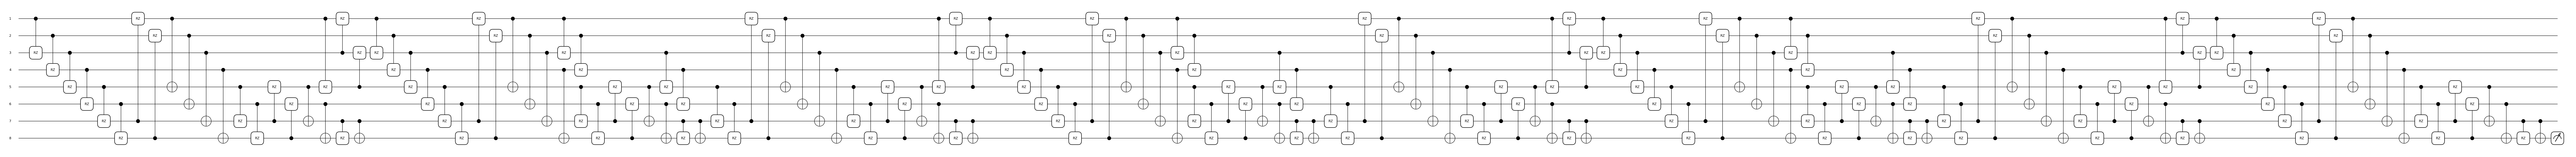

In [37]:
N = 8
# level 1
m1_1 = Qconv(2)
m1_2 = Qpool(filter="left")
# level 2
m2_1 = m1_1 + m1_2
# level 3
m3_1 = Qfree(N) + m2_1 * int(np.log2(N))
final_motif = (m3_1 + Qfree([1, 3, 5]) + Qconv(5) + m3_1) * 4

# Get param info
total_coef_count, coef_indices  = get_param_info_pennylane(final_motif)
params = np.random.uniform(0,np.pi,total_coef_count)

# Draw
fig, ax = qml.draw_mpl(circuit)(final_motif, params)

## Multiscale Entanglement Renormalization Ansatz (MERA)

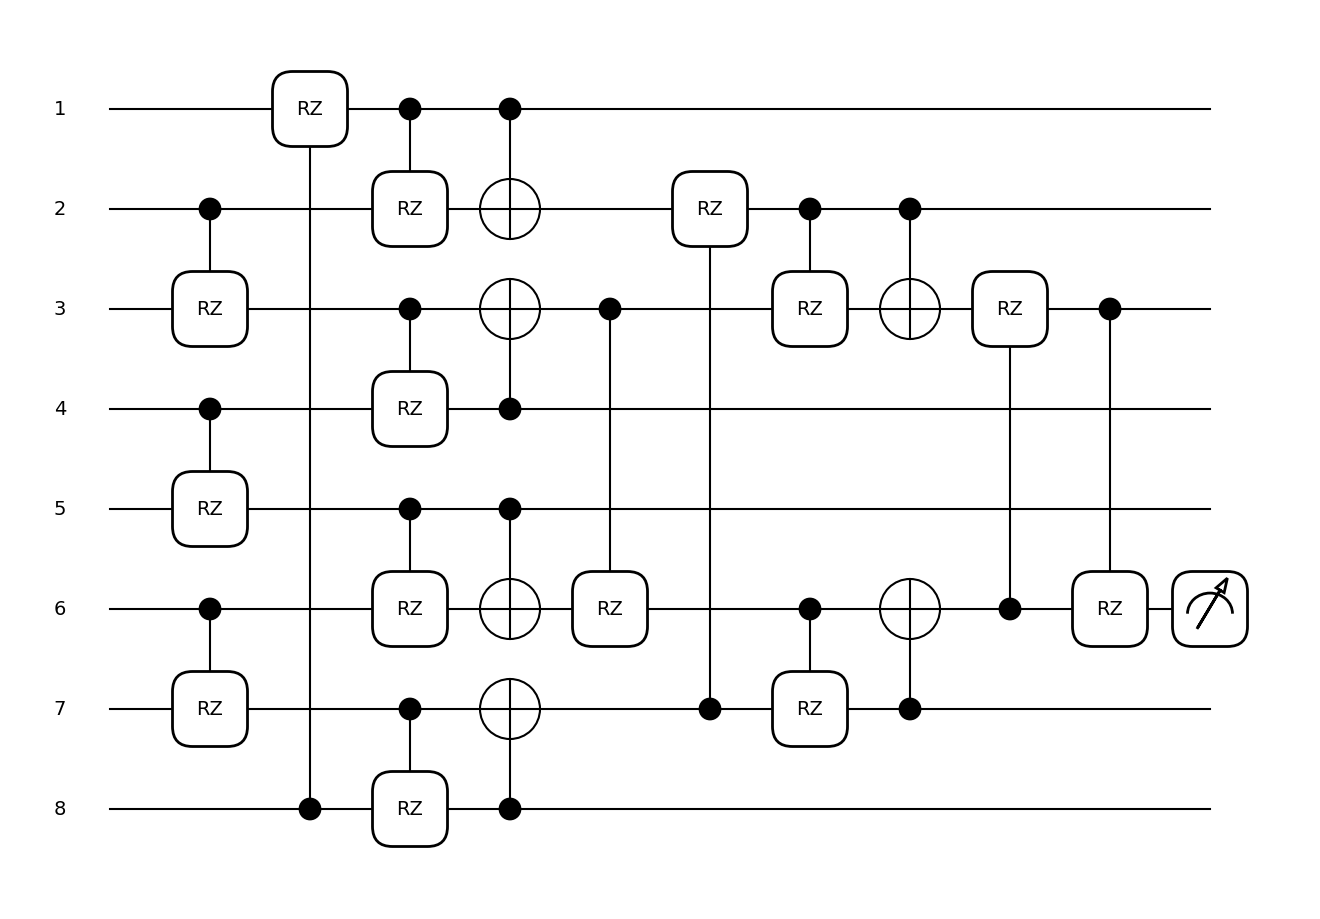

In [38]:
### MERA like
N = 8
# level 1
m1_1 = Qconv(1, 2)
m1_2 = Qconv(1, 2, 1)
m1_3 = Qpool(filter="1001")
m1_4 = Qpool(2, filter="001001")
m1_5 = Qpool(filter="outside")
# level 2
m2_1 = m1_2 + m1_1
m2_2 = m1_3 + m1_4
m2_3 = m1_5
# level 3
m3_1 = Qfree(N) + (m2_1 + m2_2) * 2 + m2_1

# Get param info
total_coef_count, coef_indices  = get_param_info_pennylane(m3_1)
params = np.random.uniform(0,np.pi,total_coef_count)

# Draw
fig, ax = qml.draw_mpl(circuit)(m3_1, params)

## Random QCNNs

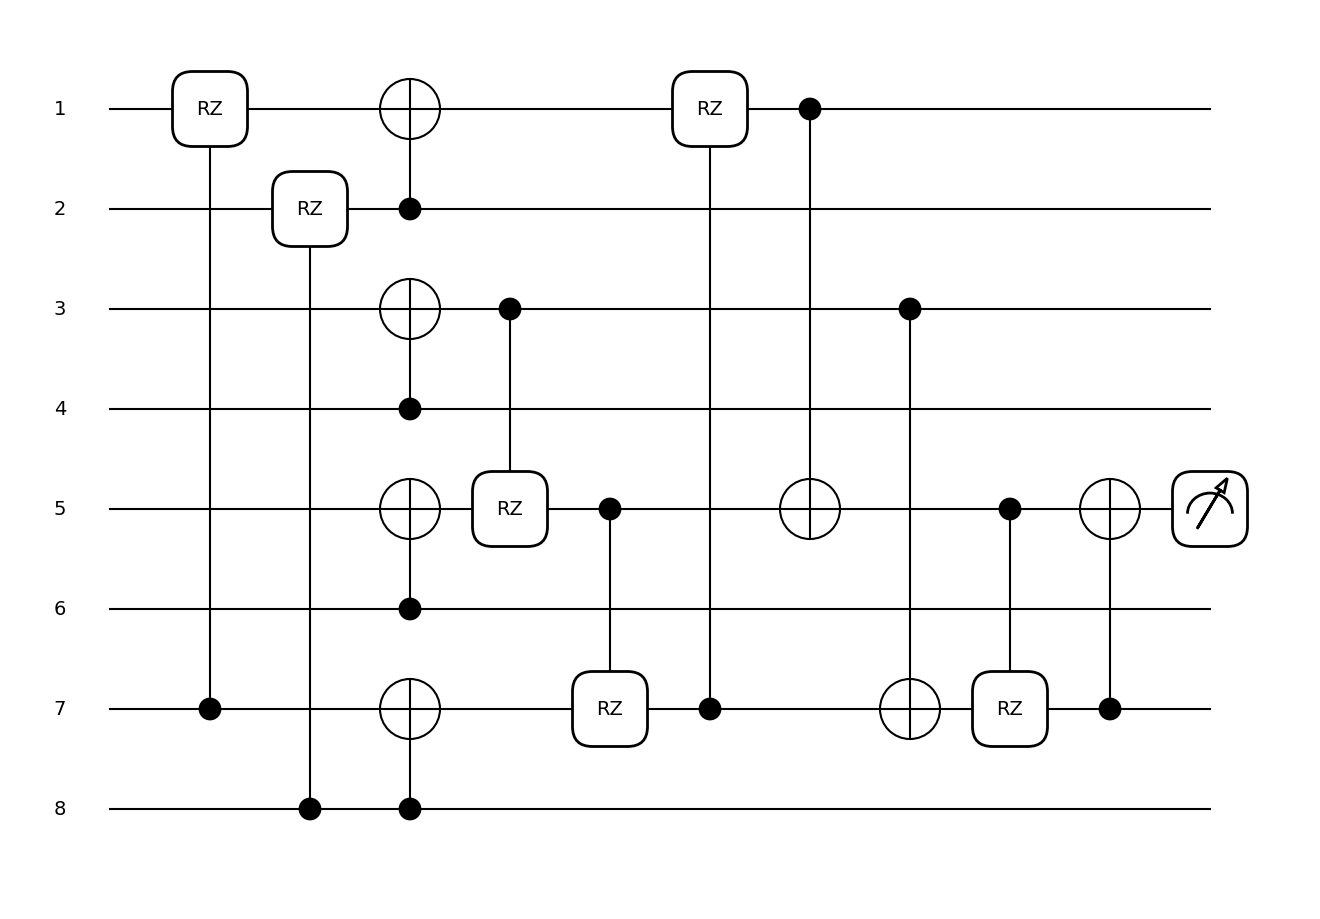

In [47]:
# More structure
import random
import operator
from functools import reduce
from dynamic_qcnn import Qmotifs

N = 8
M = Qcnn(N)
n = len(M.tail.Q_avail)
while n > 1:
    p = [
        Qpool(s_p, filter=i_filter)
        for i_filter in ("right", "left", "even", "odd", "inside", "outside")
        for s_p in range(n)
    ]
    c = [
        Qconv(stride=s_c, step=s_t, offset=s_o)
        for s_c in range(1, n, 1)
        for s_t in range(1, 2, 1)
        for s_o in range(n)
    ]# + [Qdense()]
    M = M + random.choice(c) + random.choice(p)
    n = len(M.head.Q_avail)

# Get param info
total_coef_count, coef_indices  = get_param_info_pennylane(M)
params = np.random.uniform(0,np.pi,total_coef_count)

# Draw
fig, ax = qml.draw_mpl(circuit)(M, params)

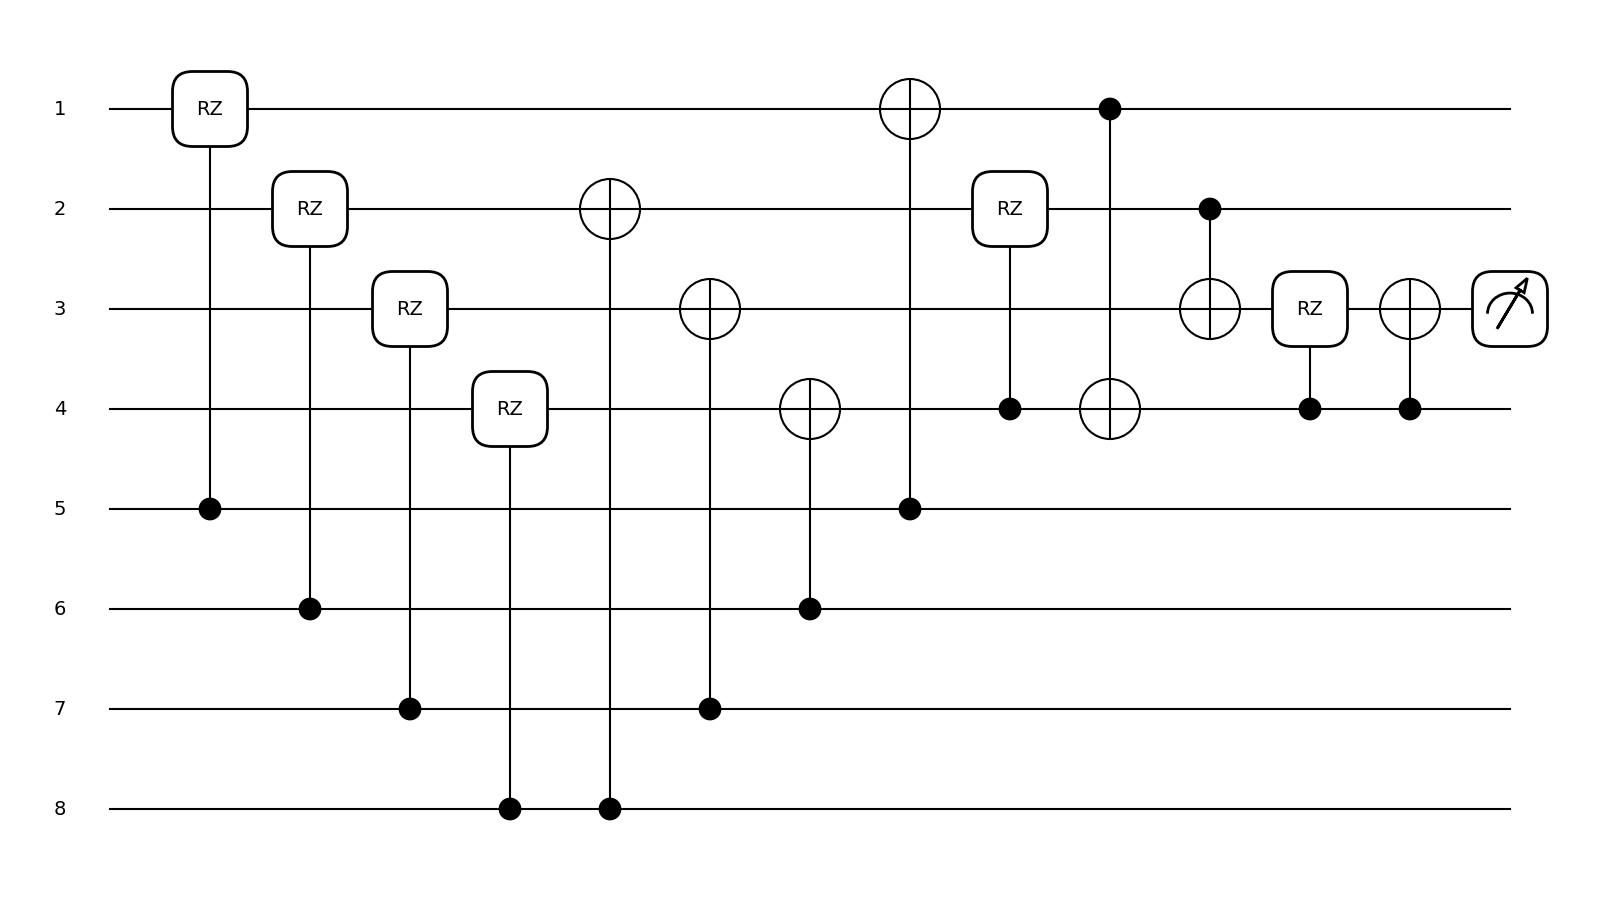

In [50]:
# loose
import random
import operator
from functools import reduce
from dynamic_qcnn import Qmotifs

N = 8
M = Qcnn(N)
n = len(M.tail.Q_avail)
while n > 1:
    p = [Qpool(s_p, filter=i_filter) for i_filter in ("right", "left", "even", "odd", "inside", "outside") for s_p in range(n)]
    c = [Qconv(stride=s_c, step=s_t, offset=s_o) for s_c in range(1, n, 1) for s_t in range(1, 2, 1) for s_o in range(n)]+ [Qdense()]
    M = M + random.choice(c) + random.choice(p)
    n = len(M.head.Q_avail)

# Get param info
total_coef_count, coef_indices  = get_param_info_pennylane(M)
params = np.random.uniform(0,np.pi,total_coef_count)

# Draw
fig, ax = qml.draw_mpl(circuit)(M, params)

## Specifying unitaries

In [51]:
# Pooling circuit
def V(bits, symbols=None):
    qml.CRZ(symbols[0], wires=[bits[0], bits[1]])
    qml.PauliX(wires=bits[0])
    qml.CRX(symbols[1], wires=[bits[0], bits[1]])

# Convolution circuit
def U(bits, symbols=None):
    qml.RZ(symbols[0], wires=bits[1])
    qml.CNOT(wires=[bits[1], bits[0]])
    qml.RZ(symbols[1], wires=bits[0])
    qml.RY(symbols[2], wires=bits[1])
    qml.CNOT(wires=[bits[0], bits[1]])
    qml.RY(symbols[3], wires=bits[1])
    qml.CNOT(wires=[bits[1], bits[0]])
    qml.RZ(symbols[4], wires=bits[0])


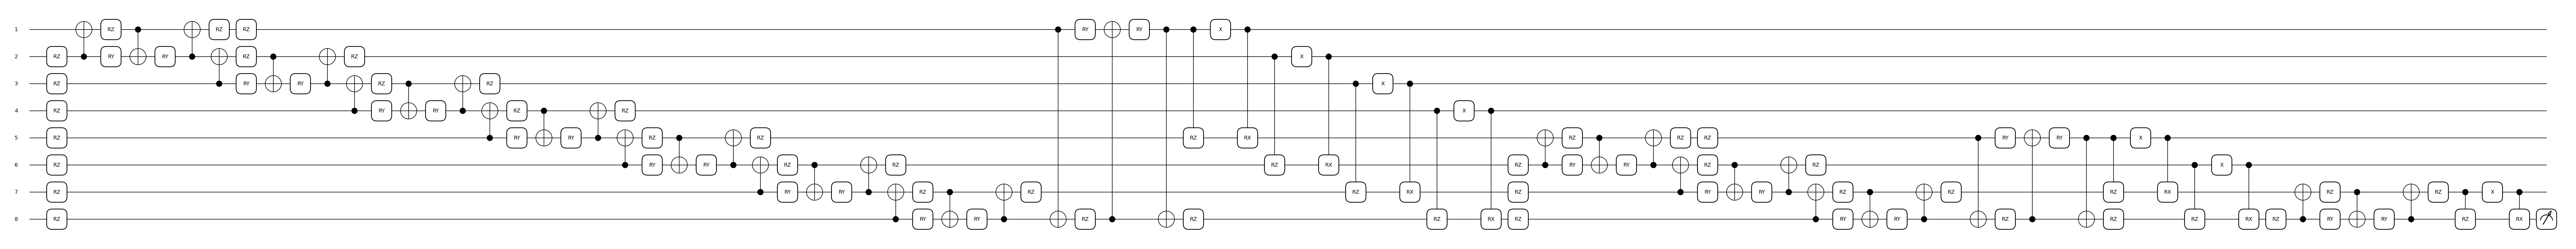

In [60]:
M = (
    Qfree(8)
    + (
        Qconv(1, convolution_mapping=(U, 5))
        + Qpool(filter="left", pooling_mapping=(V, 4))
    )
    * 3
)

# Get param info
total_coef_count, coef_indices  = get_param_info_pennylane(M)
params = np.random.uniform(0,np.pi,total_coef_count)

# Draw
fig, ax = qml.draw_mpl(circuit)(M, params)

### Cycle through unitary ansatzes

In [62]:
# Pooling circuit
def V_1(bits, symbols=None): # 1
    qml.CRX(symbols[0], wires=[bits[0],bits[1]])

def V_2(bits, symbols=None): # 0
    qml.CNOT(wires=[bits[0], bits[1]])


# Convolution circuit
def U_1(bits, symbols=None): # 1
    qml.CRZ(symbols[0], wires=[bits[0], bits[1]])

def U_2(bits, symbols=None): # 1
    qml.CRY(symbols[0], wires=[bits[0], bits[1]])

function_mappings = {
    "convolution": [(U_1, 1), (U_2, 1)],
    "pooling": [(V_1, 1), (V_2, 0)],
}


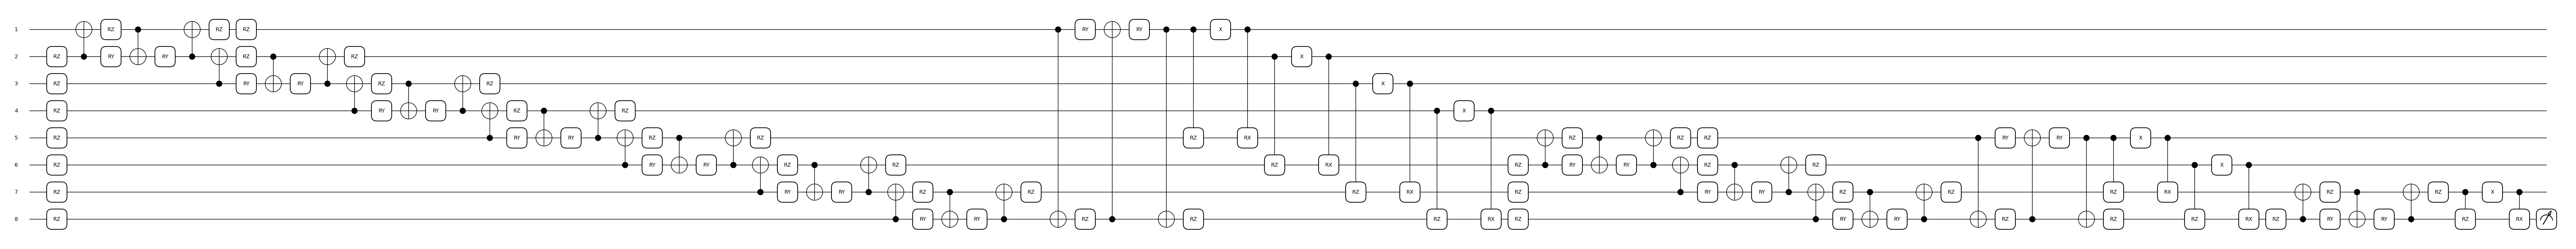

In [63]:
qcnn = Qcnn(16, function_mappings=function_mappings)

qcnn = qcnn + (Qconv(2) + Qpool(1, "outside")) * 4

# Get param info
total_coef_count, coef_indices  = get_param_info_pennylane(M)
params = np.random.uniform(0,np.pi,total_coef_count)

# Draw
fig, ax = qml.draw_mpl(circuit)(M, params)

### Plot the graph view

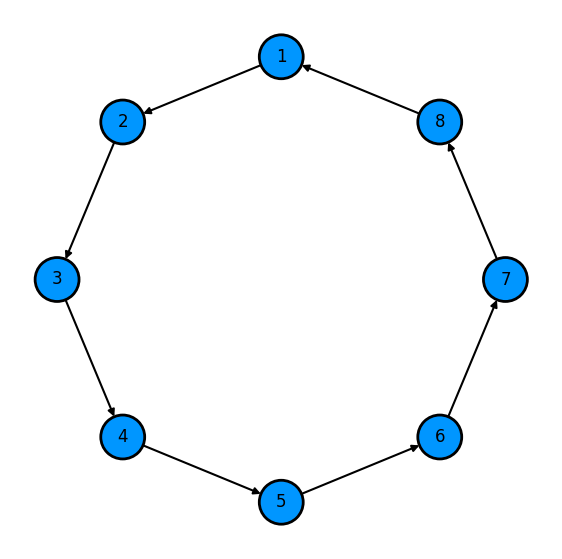

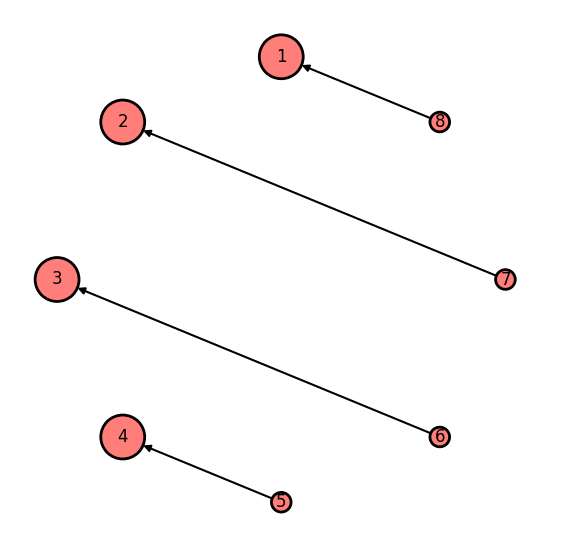

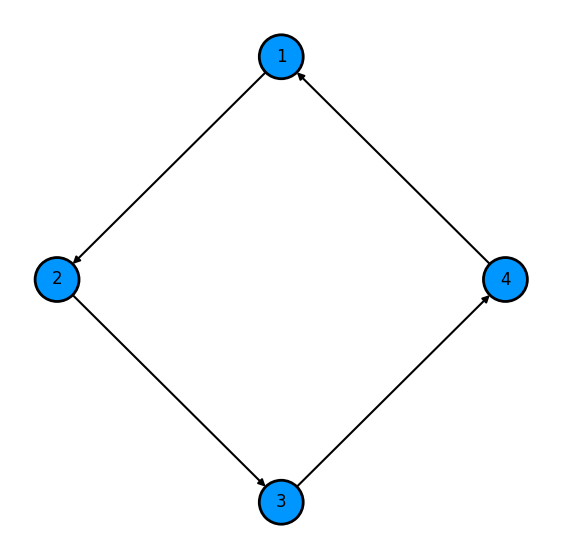

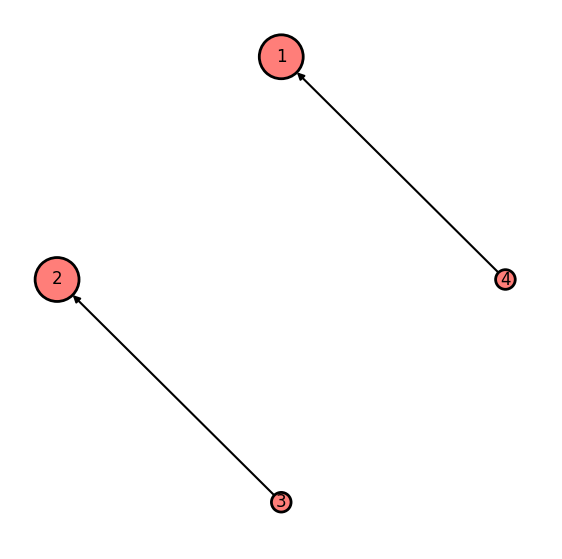

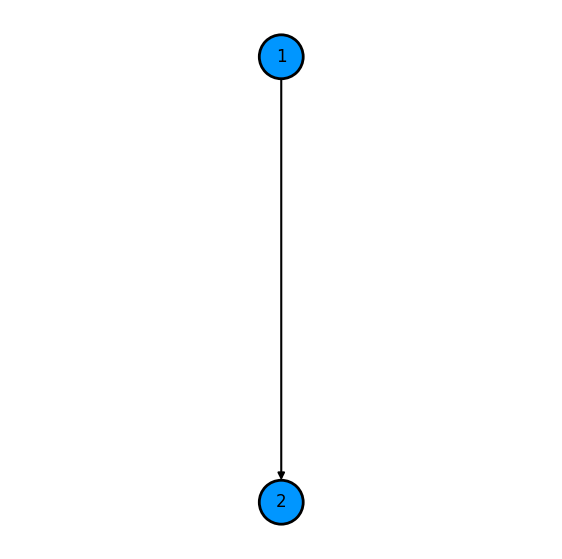

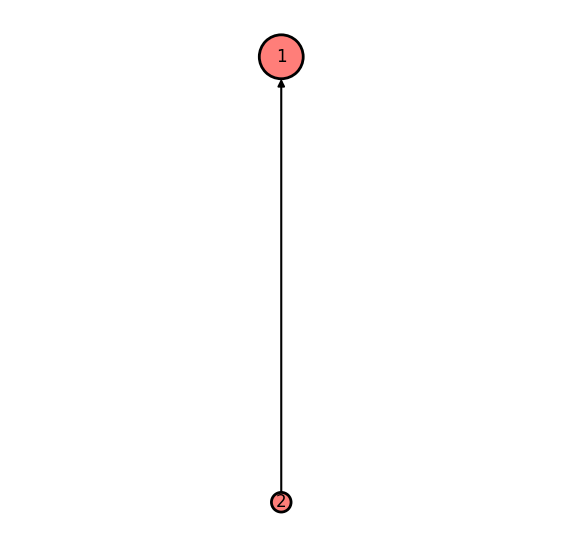

In [64]:
m = Qfree(8) + (Qconv(1) + Qpool(filter="right")) * 3
for graph in m:
    a = plot_graph(graph)